In [1]:
import random
import time
import warnings
from datetime import datetime

import torch
import os

import numpy as np
import warnings
np.warnings = warnings
import matplotlib.pyplot as plt
from tabpfn_new.scripts.differentiable_pfn_evaluation import eval_model_range
from tabpfn_new.scripts.model_builder import get_model, get_default_spec, save_model, load_model
from tabpfn_new.scripts.transformer_prediction_interface import transformer_predict, get_params_from_config, load_model_workflow

from tabpfn_new.scripts.model_configs import *

#from datasets import load_openml_list, open_cc_dids, open_cc_valid_dids
from tabpfn_new.priors.utils import plot_prior, plot_features
from tabpfn_new.priors.utils import uniform_int_sampler_f

from tabpfn_new.scripts.tabular_metrics import calculate_score_per_method, calculate_score
from tabpfn_new.scripts.tabular_evaluation import evaluate

from tabpfn_new.priors.differentiable_prior import DifferentiableHyperparameterList, draw_random_style, merge_style_with_info
from tabpfn_new.scripts import tabular_metrics
from tabpfn.notebook_utils import *

In [2]:
device = 'cpu'
base_path = '.'
max_features = 100

In [3]:
def reload_config(prior_type='forest', config_type='causal', task_type='binary', longer=0):
    config = get_prior_config(config_type=config_type)
    
    config['prior_type'] = prior_type
    
    model_string = ''
    
    config['epochs'] = 12000
    config['recompute_attn'] = True

    config['max_num_classes'] = 10
    config['num_classes'] = uniform_int_sampler_f(2, config['max_num_classes'])
    config['balanced'] = False
    model_string = model_string + '_multiclass'
    
    model_string = model_string + '_'+datetime.now().strftime("%m_%d_%Y_%H_%M_%S")
    
    return config, model_string

In [4]:
prior_type = 'mlp'
config, model_string = reload_config(prior_type, longer=1)

config['differentiable'] = True
config['flexible'] = True
config['bptt_extra_samples'] = None

# diff
config['output_multiclass_ordered_p'] = 0.0
del config['differentiable_hyperparameters']['output_multiclass_ordered_p']



config['sampling'] = 'normal' # vielleicht schlecht?
del config['differentiable_hyperparameters']['sampling']

config['pre_sample_causes'] = True
# end diff

config['multiclass_loss_type'] = 'nono' # 'compatible'
config['normalize_to_ranking'] = False # False

config['categorical_feature_p'] = 0 # diff: .0

# turn this back on in a random search!?
config['nan_prob_no_reason'] = .0
config['nan_prob_unknown_reason'] = .0 # diff: .0
config['set_value_to_nan'] = .0 # diff: 1.

config['normalize_with_sqrt'] = False

config['new_mlp_per_example'] = True
config['prior_mlp_scale_weights_sqrt'] = True
config['batch_size_per_gp_sample'] = None

config['normalize_ignore_label_too'] = False

config['differentiable_hps_as_style'] = False
config['max_eval_pos'] = 1000

config['random_feature_rotation'] = True
config['rotate_normalized_labels'] = True

config["mix_activations"] = True # False heisst eig True

config['emsize'] = 512
config['nhead'] = config['emsize'] // 128
config['bptt'] = 1024+128
config['canonical_y_encoder'] = False

    
config['aggregate_k_gradients'] = 64
config['batch_size'] = 1*config['aggregate_k_gradients']
config['num_steps'] = 64*4//config['aggregate_k_gradients']
config['epochs'] = 50

config['total_available_time_in_s'] = None #60*60*22 # 22 hours for some safety...

config['train_mixed_precision'] = False
config['efficient_eval_masking'] = True

# mlp params
config['is_causal'] = True
config['num_causes'] = 5
config['prior_mlp_hidden_dim'] = 50
config['num_layers'] = 4
config['noise_std'] = 0.05
config['init_std'] = 0.05
config['y_is_effect'] = True
config['pre_sample_weights'] = True
config['prior_mlp_dropout_prob'] = 0
config['pre_sample_causes'] = True
config["prior_mlp_activations"] = torch.nn.ReLU
config["block_wise_dropout"] = True
config["sort_features"] = False
config["in_clique"] = False

# general data params
config['balanced'] = True
config['max_num_classes'] = 10
config['max_features'] = 100
config['num_features_used'] = 100

config['differentiable'] = True
config['flexible'] = True

# forest params
config["min_features"] = 100
config["max_features"] = 100
config["n_samples"] = 1000
config["max_num_classes"] = 2
config["base_size"] = 1000
config["n_estimators"] = 1
config["min_depth"] = 1
config["max_depth"] = 25
config["categorical_x"] = False
config["data_sample_func"] = "mnd"
config["comp"] = False

config['num_classes'] = 2
config["balanced"] = False
config['multiclass_type'] = 'imbalanced_binarize'
del config['differentiable_hyperparameters']['multiclass_type']

config["prior_type"] = "forest"
config["microbiome_test"] = True
config["weight_classes"] = True
config["run_name"] = "forest_weighted_softmax"

config["lr"] = 1e-6

config_sample = evaluate_hypers(config)
'''for key in config_sample:
    #if key == "check_is_compatible":
    print(key, config_sample[key])
for key in config_sample["differentiable_hyperparameters"]:
    print(key, config_sample["differentiable_hyperparameters"][key])'''

'for key in config_sample:\n    #if key == "check_is_compatible":\n    print(key, config_sample[key])\nfor key in config_sample["differentiable_hyperparameters"]:\n    print(key, config_sample["differentiable_hyperparameters"][key])'

In [5]:
model = get_model(config_sample, device, should_train=True, verbose=1)

Using style prior: True
Using cpu:0 device
Using a Transformer with 25.81 M parameters
                    accuracy  precision    recall   roc_auc
Micriobiome TabPFN   0.70404   0.042755  0.173616  0.456642
-----------------------------------------------------------------------------------------
| end of epoch   1 | time: 251.60s | mean loss  0.68 |  lr1e-06 |  data time  0.07 step time  0.99 forward time  0.37 nan share  0.00 ignore share (for classification tasks) 0.0000
-----------------------------------------------------------------------------------------
                    accuracy  precision    recall   roc_auc
Micriobiome TabPFN  0.713549   0.038362  0.162241  0.454752
-----------------------------------------------------------------------------------------
| end of epoch   2 | time: 257.86s | mean loss  0.67 |  lr9.990133642141357e-07 |  data time  0.07 step time  1.33 forward time  0.49 nan share  0.00 ignore share (for classification tasks) 0.0000
-------------------------

In [6]:
import os
def load_train_results(name):
    dir_path = os.path.abspath(os.getcwd())
    path = dir_path + f"/logs/trainrun_{name}"
    losses = torch.load(path+"/losses")
    mb_results = torch.load(path+"/mb_results")
    return losses, mb_results

In [7]:
def plot_metrics(losses, results, metrics, name):
    plt.figure(1)
    plt.subplot(211)
    for ii, m in enumerate(metrics):
        plt.plot(results[:,ii], label=m)
    plt.ylabel("score")
    plt.title(name)
    plt.legend()
    plt.subplot(212)
    plt.plot(losses)
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.show()

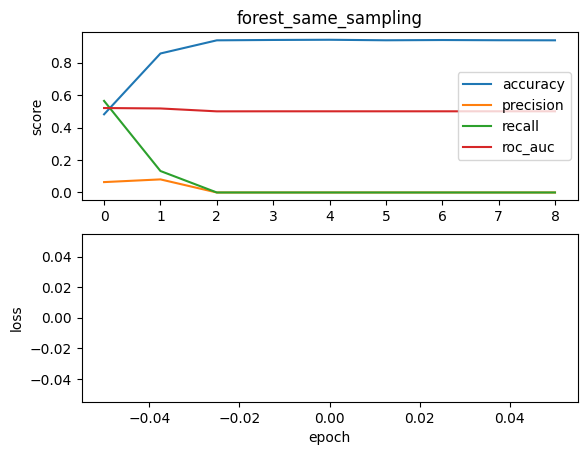

In [8]:
name = "forest_same_sampling"
metrics = ["accuracy", "precision", "recall", "roc_auc"]
losses, mb_results = load_train_results(name)
plot_metrics(losses, mb_results, metrics, name)